# ssp.train.py

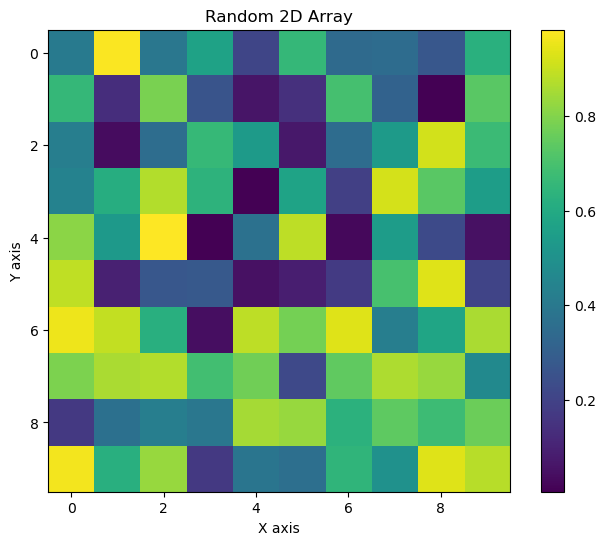

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'

AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

batch_size = 32


class spikedataset(Dataset):
    def __init__(self, path, transform = None):    
        self.transform = transform
        self.spike = torch.load(path)
        
    def __getitem__(self, index):
        spike = self.spike[index]            
        if self.transform is not None:
            spike = self.transform(spike)
        return spike
    
    def __len__(self):
        return len(self.spike)

train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)





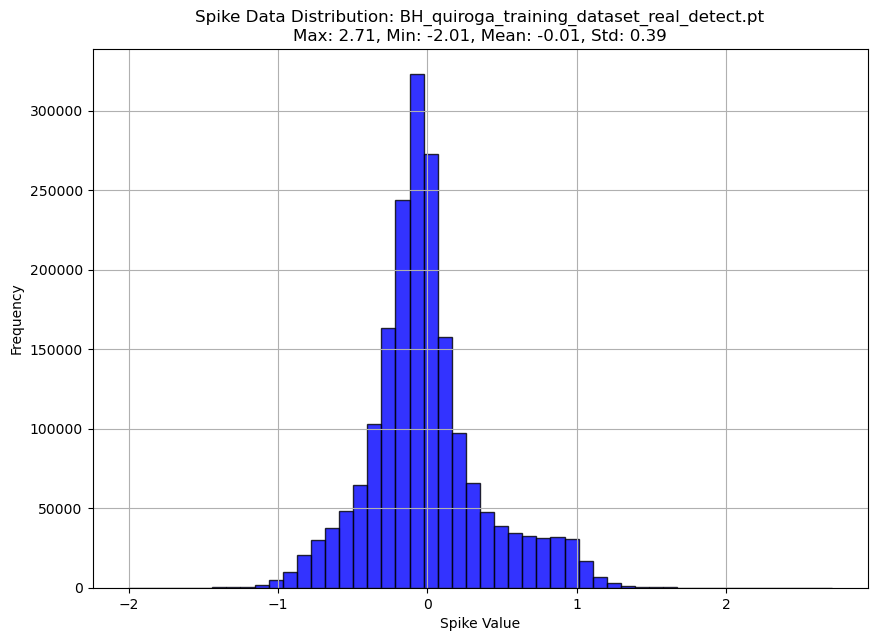

In [8]:
import matplotlib.pyplot as plt
import torch

# 데이터 전체를 수집
all_data = []
for batch in train_loader:
    all_data.extend(batch.numpy())

# 데이터를 Flatten (필요시)
all_data = torch.tensor(all_data).flatten().numpy()

# 데이터 통계 계산
data_max = all_data.max()
data_min = all_data.min()
data_mean = all_data.mean()
data_std = all_data.std()

# 히스토그램으로 분포 시각화
plt.figure(figsize=(10, 7))
plt.hist(all_data, bins=50, alpha=0.8, color='blue', edgecolor='black')

# 제목 및 통계 표시
title = f"Spike Data Distribution: {AE_train_path_real_detect}\n"
stats = f"Max: {data_max:.2f}, Min: {data_min:.2f}, Mean: {data_mean:.2f}, Std: {data_std:.2f}"
plt.title(title + stats, fontsize=12)

# 축 레이블 및 기타 설정
plt.xlabel('Spike Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [24]:
import torch

# 예제 16x50 텐서 생성
batch = 2
level_num = 3
time = 4

spike = torch.randn(batch, time)

print('1spike',spike)
spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
print('1spike',spike)





1spike tensor([[-0.6345,  1.0082,  0.1136,  0.0464],
        [-1.1873,  0.0096,  0.9732, -0.0071]])
1spike tensor([[[-0.6345, -0.6345, -0.6345],
         [ 1.0082,  1.0082,  1.0082],
         [ 0.1136,  0.1136,  0.1136],
         [ 0.0464,  0.0464,  0.0464]],

        [[-1.1873, -1.1873, -1.1873],
         [ 0.0096,  0.0096,  0.0096],
         [ 0.9732,  0.9732,  0.9732],
         [-0.0071, -0.0071, -0.0071]]])


In [ ]:

spike = (spike > levels).to(torch.float)
print('3spike',spike)

In [ ]:

levels = [0.1 + 0.2 * i for i in range(5)]
levels = torch.tensor(levels)
levels=levels.repeat(4,1).permute(1,0)


In [22]:
import torch

# 예제 16x50 텐서 생성
batch = 2
level_num = 3
length = 4


spike = torch.randn(batch, length)

spike = spike.to(device) # batch, time
print('1spike',spike)
spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
spike = (spike > levels).to(torch.float)
print('3spike',spike)



print('tensor', tensor)

# 새로운 차원 추가 및 복제
tensor_reshaped = tensor.unsqueeze(2).repeat(1, 1, 5).permute(0, 2, 1)
print('tensor_reshaped', tensor_reshaped, tensor_reshaped.shape)


levels = [0.1 + 0.2 * i for i in range(5)]
levels = torch.tensor(levels)
levels=levels.repeat(4,1).permute(1,0)
print('levles',levels.shape)
print(levels)
                      
# 결과 출력
print((tensor_reshaped > levels).to(torch.float))  # torch.Size([16, 50, 50])
print(tensor_reshaped.shape)  # torch.Size([16, 50, 50])


tensor tensor([[-0.5784,  1.2851,  0.4910, -0.9624],
        [-0.4541, -0.2865,  1.9781,  0.5794]])
tensor_reshaped tensor([[[-0.5784,  1.2851,  0.4910, -0.9624],
         [-0.5784,  1.2851,  0.4910, -0.9624],
         [-0.5784,  1.2851,  0.4910, -0.9624],
         [-0.5784,  1.2851,  0.4910, -0.9624],
         [-0.5784,  1.2851,  0.4910, -0.9624]],

        [[-0.4541, -0.2865,  1.9781,  0.5794],
         [-0.4541, -0.2865,  1.9781,  0.5794],
         [-0.4541, -0.2865,  1.9781,  0.5794],
         [-0.4541, -0.2865,  1.9781,  0.5794],
         [-0.4541, -0.2865,  1.9781,  0.5794]]]) torch.Size([2, 5, 4])
levles torch.Size([5, 4])
tensor([[0.1000, 0.1000, 0.1000, 0.1000],
        [0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.7000, 0.7000, 0.7000, 0.7000],
        [0.9000, 0.9000, 0.9000, 0.9000]])
tensor([[[0., 1., 1., 0.],
         [0., 1., 1., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 